# **Exploring ARIMA and SARIMA for Temperature Prediction: A Practical Approach**

## **Table of Contents**
1. **Introduction**
   - Weather Forecasting
   - Timeseries Forecasting Models
   - Objectives

2. **Pre-requisites**
   - Data Overview
   - Python Libraries
   - Data Pre-processing
     - Loading and Exploring the data
     - Masking the Data

3. **Data Modelling**
   - Introduction to ARIMA and SARIMA Models
     - ARIMA
     - SARIMA
     - Autocorrelation Function and Augmented Dickey-Fuller Test
   - Grid Search for Optimal Parameters
     - Optimal ARIMA Parameter Search (p, d, q)
     - Optimal SARIMA Parameter Search (p, d, q, P, D, Q, S)

4. **Results and Discussion**
   - ARIMA Model Results
     - Model Fitting, Diagnostics, and Visualization
   - SARIMA Model Results
     - Model Fitting, Diagnostics, and Visualization
   - Comparative Analysis of ARIMA and SARIMA
     - Statistical Diagnostics vs. Predictive Power
     - Residual Diagnostics and Parameter Significance
     - Implications for Model Choice

5. **Conclusion**

6. **References**


---

> *Note: This is a Markdown document written and compiled in Jupyter Notebook.*

## **Introduction**

### **Weather Forecasting**

Temperature is a fundamental climate variable, influencing numerous sectors such as agriculture, energy consumption, public health, and infrastructure planning. Accurate temperature forecasting can aid in managing energy resources, anticipating agricultural output, and preparing for extreme weather events such as heatwaves or cold snaps. As global temperatures continue to rise due to climate change, the ability to forecast short- and long-term temperature trends has become more critical.

Weather forecasting models (e.g., WRF, GFS) are numerical weather prediction (NWP) models that simulate atmospheric processes and drivers (e.g., Temperature) based on physical equations, making them effective for short-term, high-resolution weather forecasting. These models utilize large-scale environmental conditions (e.g., from satellite data or global models) as initial inputs and integrate these conditions over time to simulate future weather patterns. As such, they provide detailed, high-resolution forecasts across spatial grids and are particularly useful for short-term and regional weather forecasting. However, there are limitations. The primary constraint is that they *require substantial computational resources due to the need for high-resolution grids, complex physics-based equations, and integration over time*. Running a WRF model for even a short forecast period can take several hours or days, especially at finer spatial resolutions. Simply put, these are not meant to be executed on a PC or laptop (which I am using right now.) This brings us to the Star of this mini-project: Statistical timeseries forecasting. 

Time series models are computationally lightweight compared to NWP models and differ fundamentally from NWP models in that they are data-driven rather than physics-driven. They focus on trends and seasonal variations within a univariate time series and can be executed on basic computing infrastructure with minimal resource requirements. This makes them highly accessible and efficient, even for forecasting over extended periods. While timeseries forecasting is effective for long-term forecasting, it lacks the ability to model dynamic weather events and spatial details, which are strengths of WRF. Thus, for extreme weather or spatially explicit forecasts, NWP models remain essential.

### **Timeseries Forecasting Models**

Among the most commonly used techniques for time series forecasting are the AutoRegressive Integrated Moving Average (ARIMA) model and its seasonal variant, the Seasonal AutoRegressive Integrated Moving Average (SARIMA). These models allow for capturing the linear dependencies within time series data and accounting for seasonal patterns, making them effective for predicting climate variables such as temperature, humidity, or precipitation.

The ARIMA model is characterized by three key parameters: autoregressive order (p), differencing order (d), and moving average order (q). These parameters help model the underlying structure of the time series, allowing the forecast to capture temporal patterns without seasonal components. The SARIMA model extends ARIMA by introducing additional parameters to account for seasonality: seasonal autoregressive order (P), seasonal differencing (D), seasonal moving average order (Q), and the length of the seasonal cycle (S). Together, these parameters enable the SARIMA model to predict time series data that exhibit both trend and seasonality.

### **Objectives**

The objective of this document is to provide a detailed, practical approach to modeling temperature data using both ARIMA and SARIMA models. Specifically, we aim to:
1. Explore and apply grid search techniques to determine optimal model parameters for both ARIMA and SARIMA.
2. Fit both models to a temperature dataset and evaluate their performance using key metrics such as the Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).
3. Compare the performance of the ARIMA and SARIMA models to determine which is better suited for predicting future temperature trends.

Through this process, the document intends to serve as a practical guide for applying ARIMA and SARIMA models to time series data, with a specific focus on temperature forecasting.

## **Pre-requisites**

### **Data Overview**

ERA5 reanalysis data is downloaded from the Copernicus Climate Data Store. Monthly data on 2-meter air temperature and specific humidity for the Indian Subcontinent from January 2014 to December 2023 were selected. In the previous project, data for the entire Subcontinent was used; however, the focus of the current project will be on India.

**Dimensions:**

> Longitude: 65.0°E to 100.0°E, with a resolution of 0.25°.
> Latitude: 40.0°N to 5.0°N, with a resolution of 0.25°.
> Time: Monthly data from January 2014 to December 2023.

**Data Variables:**

> t2m (2-meter air temperature) and sp (Specific humidity): Both variables are provided on a regular grid of latitude, longitude, and time, with data in float64 format.

Similar to the previous project, only `t2m` data will be analyzed here.

### **Python Libraries**

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import itertools
import warnings

# Geospatial and climate analysis
import regionmask
import geopandas as gpd
import xarray as xr

# Cartography and Visualization
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Statistical modeling and Time series analysis
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Statistical and metrics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

### **Data Pre-processing**

#### **Loading and Exploring the data**

In [2]:
# Load the dataset
file_path = 'C:/Users/Saurabh Kelkar/Documents/Python/climate-data-analysis-python/era5_data_IND.nc'
ds = xr.open_dataset(file_path)

# Explore the dataset structure
print(ds)

<xarray.Dataset> Size: 38MB
Dimensions:    (longitude: 141, latitude: 141, time: 120)
Coordinates:
  * longitude  (longitude) float32 564B 65.0 65.25 65.5 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 564B 40.0 39.75 39.5 39.25 ... 5.5 5.25 5.0
  * time       (time) datetime64[ns] 960B 2014-01-01 2014-02-01 ... 2023-12-01
Data variables:
    t2m        (time, latitude, longitude) float64 19MB ...
    sp         (time, latitude, longitude) float64 19MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-19 08:42:57 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


Let's extract the variable of interest.

In [3]:
# Extracting 2m Air Temperature
temp = ds.t2m
print(temp[:1])

<xarray.DataArray 't2m' (time: 1, latitude: 141, longitude: 141)> Size: 159kB
[19881 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 564B 65.0 65.25 65.5 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 564B 40.0 39.75 39.5 39.25 ... 5.5 5.25 5.0
  * time       (time) datetime64[ns] 8B 2014-01-01
Attributes:
    units:      K
    long_name:  2 metre temperature


As we can see, the temperature is in Kelvin (K). It would be better to convert it to Celcius for better readability.

In [4]:
# Converting temperature from Kelvin to Celcius.
temp_C = temp - 273.15

# Assign variable name and units
temp_C.attrs['units'] = 'Celsius'
temp_C.attrs['long_name'] = '2 metre temperature'

print(temp_C[:1])

<xarray.DataArray 't2m' (time: 1, latitude: 141, longitude: 141)> Size: 159kB
array([[[ 2.73811128,  2.96556467,  2.72826954, ..., -5.66344824,
         -5.66235472, -5.77280083],
        [ 3.60418379,  3.67745003,  3.3045577 , ..., -5.90183689,
         -5.91386568, -5.89199516],
        [ 4.02956537,  4.26357991,  4.24061587, ..., -4.18937533,
         -4.69677135, -5.09372125],
        ...,
        [26.29922041, 26.31452977, 26.31671682, ..., 26.65789691,
         26.70929262, 26.50370975],
        [26.31671682, 26.33421324, 26.35389671, ..., 26.66773864,
         26.68742211, 26.49386802],
        [26.34842908, 26.36701902, 26.39107659, ..., 26.6447746 ,
         26.65789691, 26.51573854]]])
Coordinates:
  * longitude  (longitude) float32 564B 65.0 65.25 65.5 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 564B 40.0 39.75 39.5 39.25 ... 5.5 5.25 5.0
  * time       (time) datetime64[ns] 8B 2014-01-01
Attributes:
    units:      Celsius
    long_name:  2 metre temperature


#### **Masking the Data** 

The downloaded data covers the entire Indian subcontinent. In the previous [project](https://github.com/Skgit18/Python-Projects/blob/main/Project-1/Temperature_Trend_MD_notebook.ipynb), the data was used in its entirety; however, this project specifically requires data for India. Therefore, the unneeded data or grids must be masked out.

To achieve this, a shapefile for India from www.geoboundaries.org is used. This shapefile represents India's administrative boundaries at the first administrative level (ADM1). I have chosen a simplified version of the shapefile to reduce file size and processing time while preserving the general boundary shapes.

In [5]:
# Load the shapefile
PATH_TO_SHAPEFILE = 'C:/Users/Saurabh Kelkar/Documents/Python/Project-2/IND-shp/geoBoundaries-IND-ADM1_simplified.shp'
ind = gpd.read_file(PATH_TO_SHAPEFILE)

# Dissolve the state boundaries
ind_adm0 = ind.dissolve(by='shapeGroup')

# Save the resulting ADM0 shapefile
adm0_shapefile = "C:/Users/Saurabh Kelkar/Documents/Python/Project-2/IND-shp/ind_adm0.shp"
ind_adm0.to_file(adm0_shapefile)

Shapefile is now ready to mask the temperature data.

In [6]:
# Masking temperature data to Indian region
# Load the shapefile using geopandas
gdf = gpd.read_file(adm0_shapefile)

# Create a mask using regionmask
# regionmask requires the geometry to be passed, so we'll extract it from the GeoDataFrame
regions = regionmask.Regions(gdf['geometry'])

# Apply the mask to the NetCDF data
mask = regions.mask(temp_C['longitude'], temp_C['latitude'])

# Use the mask to filter the data
# Here we apply the mask to a specific variable (temperature), replacing values outside the region with NaN
masked_data = temp_C.where(mask == 0) # (mask != 0) would select all regions except the region specified by the shapefile.

# Save the masked data to a new NetCDF file
output_file = 'C:/Users/Saurabh Kelkar/Documents/Python/Project-2/masked_era5_t2m_IND.nc'
masked_data.to_netcdf(output_file)

print(f"Masked data saved to {output_file}")

Masked data saved to C:/Users/Saurabh Kelkar/Documents/Python/Project-2/masked_era5_t2m_IND.nc


Perfect! The code worked without any issue!

Let's plot the masked data and see how it looks

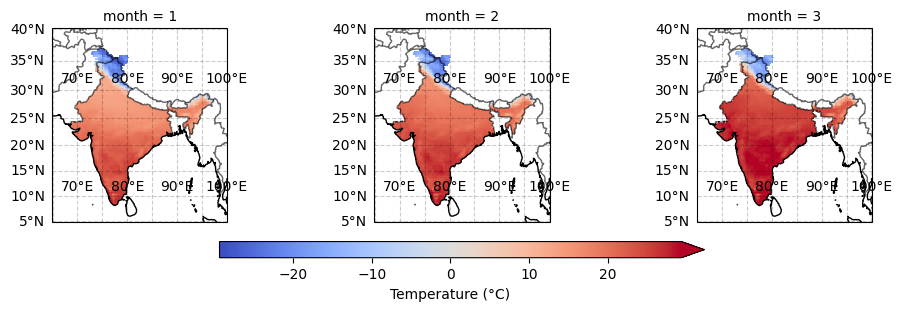

In [7]:
# Plotting masked temperature
temp = masked_data.groupby('time.month').mean(dim='time')

fg = temp.isel(month=[0,1,2]).plot(  # For all 12 months plot: month=np.arange(12)
    col="month",                     # Specify that plots are separate for each month
    #col_wrap=4,                     # Wrap into 4 columns, so 4x3 grid for 12 months
    transform=ccrs.PlateCarree(),    # Tells the plotting library that this data is in latitude-longitude coordinates.
    subplot_kws={"projection": ccrs.Mercator()}, # PlateCarree(); LambertConformal(central_longitude=85, central_latitude=20)
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.5, "aspect": 30, "pad": 0.08, "label": 'Temperature (°C)'},
    cmap = 'coolwarm',
    robust=True,                   # Automatically choose color limits to exclude outliers
)

# Add a coastline to each subplot
fg.map(lambda: plt.gca().coastlines())
    
# Add gridlines and titles
for ax in fg.axs.flat:
    gl = ax.gridlines(draw_labels=True, x_inline=True, color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.6)


Beautiful!!

The plot above shows that the northernmost part of India, specifically the Jammu and Kashmir (J&K) region, has its borders cut off. This is likely due to default boundary representation in Python’s `geopandas`. However, the shapefile used for the data mask is based on India’s 2011 census, which reflects different borders for J&K. 

> *This discrepancy in boundary representation is **purely technical**, and readers are kindly requested to refrain from drawing political conclusions.*

With this, we can now dive into Statistical-Timeseries forecasting of temperature.

## Data Modelling

### Introduction to ARIMA and SARIMA Models

#### ARIMA

ARIMA, which stands for **AutoRegressive Integrated Moving Average**, is a widely used statistical model for time series analysis and forecasting *(1, 2)*. It combines three key components:

1. **Autoregressive (AR)**: This component models the relationship between an observation and a number of lagged observations (previous values). The parameter $p$ indicates the number of lagged terms included.

2. **Integrated (I)**: This part involves differencing the time series data to make it stationary, meaning it removes trends or seasonality from the data. The parameter $d$ represents the number of times the data needs to be differenced.

3. **Moving Average (MA)**: This component models the relationship between an observation and a residual error from a moving average model applied to lagged observations. The parameter $q$ indicates the number of lagged forecast errors in the prediction equation.

ARIMA is particularly effective for modeling time series data that exhibit trends and non-seasonal patterns. It is commonly used in various fields, including finance, economics, and environmental science, to forecast future values based on historical data.

#### SARIMA

SARIMA, or **Seasonal AutoRegressive Integrated Moving Average**, is an extension of the ARIMA model specifically designed to handle time series data with seasonal components. Here’s a detailed overview: SARIMA incorporates additional parameters to account for seasonality in the data. In addition to the three parameters (p, d, q) for the non-seasonal part, SARIMA adds three more (P, D, Q, S) for the seasonal part *(1, 3)*. This allows it to model seasonal patterns effectively.

A SARIMA model is typically expressed as: ${SARIMA}(p, d, q) x (P, D, Q, S)$

   - **p**: Order of the autoregressive part.
   - **d**: Degree of differencing.
   - **q**: Order of the moving average part.
   - **P**: Seasonal autoregressive order.
   - **D**: Seasonal differencing order.
   - **Q**: Seasonal moving average order.
   - **S**: The number of periods in each season (e.g., 12 for monthly data with yearly seasonality).

SARIMA can handle multiple seasonal periods and complex cyclical patterns, making it suitable for various applications such as weather forecasting and sales data analysis where seasonality is prominent. The model automatically applies differencing to regular and seasonal components, enhancing its ability to simultaneously manage trends and seasonal fluctuations without requiring manual preprocessing *(3)*.

While both ARIMA and SARIMA can provide forecasts under certain conditions, they require careful parameter selection, which can be a trial-and-error process. Later sections will discuss more about parameter selection.

Firstly, let's convert the spatial data to a `pandas` timeseries.

#### Autocorrelation Function and Augmented Dickey-Fuller Test

In [8]:
# let's calculate the area average of masked temperature for each month for India.

tavg = masked_data.groupby('time.month').mean(dim=['latitude', 'longitude'])
t_series = tavg.to_series()
t_series.head()

time
2014-01-01    14.746173
2014-02-01    16.801178
2014-03-01    21.262900
2014-04-01    25.764127
2014-05-01    27.667727
Name: t2m, dtype: float64

Before applying ARIMA and SARIMA to the data, we need a preliminary assessment of underlying trends, seasonality, and stationarity. For that purpose, an Autocorrelation Function (ACF) or correlogram can be useful.

The Autocorrelation Function (ACF) measures the correlation between a time series' current value and its past values. It reveals patterns, trends, and seasonality within the data. For a trend in data, shorter lags exhibit strong positive correlations due to proximity, while correlations gradually diminish as lags increase. Seasonal patterns result in larger correlations at multiples of the seasonal frequency. Stationary time series, without trends, seasonality, or changing variance, have ACF values that quickly decline to near zero. Non-stationary series exhibit a slower decline. By analyzing ACF, one can identify and understand the underlying structure of a time series, aiding in forecasting and model selection. *(4, 5)*

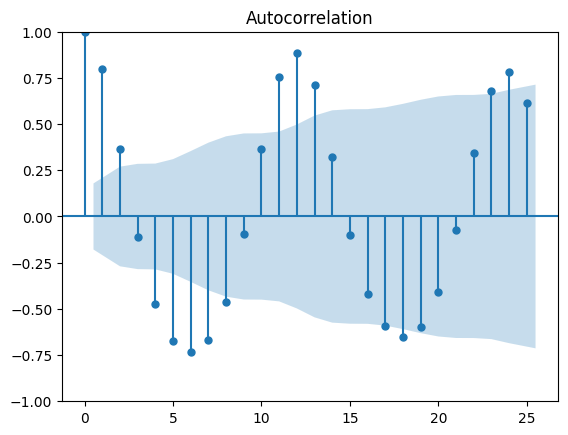

In [9]:
# plot_acf() function from statsmodels.graphics.tsaplots
plot_acf(t_series, lags = 25)
plt.show()

Initially, there is strong positive autocorrelation at the first few lags, indicating that the series has a clear trend component where the values are highly dependent on their immediate past values. Additionally, the presence of alternating positive and negative spikes suggests that there may be some seasonality embedded in the data. The gradual decay of the autocorrelation values beyond lag 10, combined with periodic spikes at higher lags, further reinforces this potential seasonality.

Moreover, the significant autocorrelations outside the confidence intervals (shaded area) indicate that the series is non-stationary, as the autocorrelation persists over several lags. This means that a transformation or differencing of the data might be necessary to achieve stationarity before applying time series forecasting models. Therefore, this ACF plot points out SARIMA as a potential model for the data, which can account for both trend and seasonal patterns to capture the underlying structure of the data.

The autocorrelation pattern observed in the ACF plot suggests that the time series is likely non-stationary, with potential trend or seasonal components. Stationarity is a key requirement for time series models like ARIMA and SARIMA to perform well. To formally confirm this non-stationarity, we will apply the Augmented Dickey-Fuller (ADF) test. It will help ascertain whether the series contains a unit root, indicating a need for transformations, such as differencing, to stabilize the mean of the series. By conducting the ADF test, we can determine whether further pre-processing steps are necessary to prepare the data for accurate modeling and forecasting.

For the ADF test, the hypothesis is as follows:

1. Null Hypothesis: The time series is non-stationary.
2. Alternative Hypothesis: The time series is stationary.

The level of significance, that is, the probability of rejecting the null hypothesis when it is true, is set to 5% or 0.05.

If the P-value > 0.05, we fail to reject the null hypothesis, implying that the time series is non-stationary. On the other hand, if the P-value <= 0.05, we reject the null hypothesis, supporting the alternative hypothesis that the time series is stationary.

In [10]:
# Augmented Dickey-Fuller (ADF) test for Stationary

stat_test = adfuller(t_series, autolag='AIC')
print("P-Value : ", stat_test[1])

# First order differencing
stat_test = adfuller(t_series.diff().dropna(), autolag='AIC')
print("P-Value : ", stat_test[1])

# Second order differencing
stat_test = adfuller(t_series.diff().diff().dropna(), autolag='AIC')
print("P-Value : ", stat_test[1])

P-Value :  0.18411195822023285
P-Value :  4.515103739430176e-19
P-Value :  4.959341436464617e-12


1. Initial Series: The first p-value is 0.184, greater than 0.05. This implies that the series is non-stationary in its original form. This confirms the trend and/or seasonality present in the data.

2. First-order Differencing: After applying the first-order differencing, the p-value drastically decreased to be significantly smaller than 0.05. This suggests that the series becomes stationary after differencing once, indicating that the trend component has been effectively removed.

3. Second-order Differencing: Applying second-order differencing further results in another small p-value indicating stationarity. However, second-order differencing is unnecessary because the series already becomes stationary after first-order differencing.

Based on this analysis, it is evident that the time series becomes stationary after first-order differencing, which will allow us to proceed with ARIMA/SARIMA modeling. The ADF test has confirmed the presence of a trend in the original series, which required differencing for stationarity, a key step for successful time series forecasting.

#### Grid Search for Optimal Parameters

Finding the optimal parameters for ARIMA and SARIMA models is a trial-and-error process. Jessica Forrest Baldini wrote a function `sarmiax_gridsearch` to find an optimal combination of parameters based on the lowest value of the Bayesian Information Criterion (**BIC**) *(6)*. However, that function finds parameters for SARIMA only. I have used the same function and its logic as a base and modified it to apply it to ARIMA and SARIMA. Though the process is an over-the-top manual approach, it does offer more control over the iterations and models compared to the `auto_arima()` function from `pmdarima`, which finds the parameter automatically.

Let's look into the modified function.

Firstly, we will define the possible combinations of the parameters by testing $p$, $d$, and $q$ each at 0, 1, and 2, as higher numbers will result in the code taking much longer to run.

In [11]:
# Define the p, d, and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate different combinations for ARIMA
pdq = list(itertools.product(p, d, q))

# Generate all different combinations for SARIMA
# Note: here we have 12 in the 's' position as we have monthly data
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

**Function Description**

Name: `arima_sarima_best_fit()`

Purpose: To find the best ARIMA/SARIMA model by iterating over different combinations of order parameters.
    
Function Arguments:

1. **ts** (*pd.Series* or *array-like*): The time series data to be modeled.
2. **pdq** (*list of tuples*): List of (p, d, q) tuples representing the non-seasonal autoregressive (AR), differencing (I), and moving average (MA) orders for the ARIMA/SARIMA model.
3. **pdqs** (*list of tuples*): List of seasonal (P, D, Q, S) tuples for SARIMA, where P is the seasonal AR order, D is the seasonal differencing order, Q is the seasonal MA order, and S is the length of the seasonal cycle. **Default** is `None` for ARIMA models.
4. **maxiter** (*int*): Maximum number of iterations for the model fitting process.
5. **freq** (*str*): Frequency of the time series (e.g., `'MS'` for monthly start, `'D'` for daily data). **Default** is `'MS'` (monthly start).
6. **model_type** (*str*): Specify the type of model to fit, either `'ARIMA'` or `'SARIMA'`. **Default** is `'ARIMA'`.

Returns:
1. **pd.DataFrame**: Sorted DataFrame with the top 5 model combinations and their AIC values.




In [12]:
# Integrated ARIMA/SARIMA Order Search Function

# Note: this code will take a while to run.

def arima_sarima_best_fit(ts, pdq, pdqs=None, maxiter=100, freq='MS', model_type='ARIMA'):
    
    ans = []

    # The computation power is limited, so this function is set to perform a maximum of 100 iterations to find 
    # the optimal order parameter. If the defined no. of iterations are enough to converge the model, 
    # python will throw a warning. Such warnings are going to be suppressed to get a clean output.

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning) 
        warnings.simplefilter("ignore", UserWarning)
        
        if model_type == 'ARIMA':
            # ARIMA: No seasonal order is provided
            for arima_order in pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(ts, order=arima_order, freq=freq)
                    output = mod.fit(maxiter=maxiter)
                    ans.append([arima_order, None, output.aic])
                except:
                    continue
        
        elif model_type == 'SARIMA' and pdqs is not None:
            # SARIMA: Iterate through both pdq and pdqs
            for arima_order in pdq:
                for sarima_order in pdqs:
                    try:
                        mod = sm.tsa.statespace.SARIMAX(ts, 
                                                        order=arima_order, 
                                                        seasonal_order=sarima_order,
                                                        enforce_stationarity=False, 
                                                        enforce_invertibility=False, freq=freq)
                        output = mod.fit(maxiter=maxiter)
                        ans.append([arima_order, sarima_order, output.aic])
                    except:
                        continue
        
        else:
            raise ValueError("Invalid model_type. Choose 'ARIMA' or 'SARIMA'. If 'SARIMA', provide pdqs parameter.")
    
    # Convert results into a DataFrame
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

    # Sort by AIC and return the top 5 combinations
    return ans_df.sort_values(by=['aic'], ascending=True).head(5)

**Optimal ARIMA Parameter Search (p, d, q)**

In [13]:
# As stated in ADF test, the timseries should be made Stationary before applying ARIMA. 
# It can be done by first differencing.
arima_sarima_best_fit(t_series.diff(), pdq)

,pdq,pdqs,aic
19,"(2, 0, 1)",None,425.294360
20,"(2, 0, 2)",None,455.215718
18,"(2, 0, 0)",None,463.315284
23,"(2, 1, 2)",None,471.006599
11,"(1, 0, 2)",None,472.761202


**Optimal SARIMA Parameter Search (p, d, q, P, D, Q, S)**

In [14]:
arima_sarima_best_fit(t_series, pdq, pdqs, model_type='SARIMA')

,pdq,pdqs,aic
521,"(2, 0, 1)","(0, 2, 2, 12)",12.000000
530,"(2, 0, 1)","(1, 2, 2, 12)",14.000000
539,"(2, 0, 1)","(2, 2, 2, 12)",16.000000
563,"(2, 0, 2)","(2, 1, 2, 12)",153.485197
554,"(2, 0, 2)","(1, 1, 2, 12)",154.225184


Unlike ARIMA, SARIMA has an in-built function for differencing. So, we do not need to apply differencing separately to the data.

## **Results and Discussion**

Let's use the optimal parameters to fit the ARIMA model and forecast temperature. But first, we need to ensure the time series has an accurate frequency.

In [15]:
# Ensure frequency is 'MS' (Month Start)
t_series = t_series.asfreq('MS')  

### ARIMA Model Results

#### Model Fitting, Diagnostics, and Visualization

                               SARIMAX Results                                
Dep. Variable:                    t2m   No. Observations:                  120
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -208.434
Date:                Mon, 21 Oct 2024   AIC                            426.867
Time:                        15:27:31   BIC                            440.805
Sample:                    01-01-2014   HQIC                           432.527
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.6932      0.415     54.671      0.000      21.880      23.507
ar.L1          1.5055      0.075     20.097      0.000       1.359       1.652
ar.L2         -0.8432      0.068    -12.385      0.0

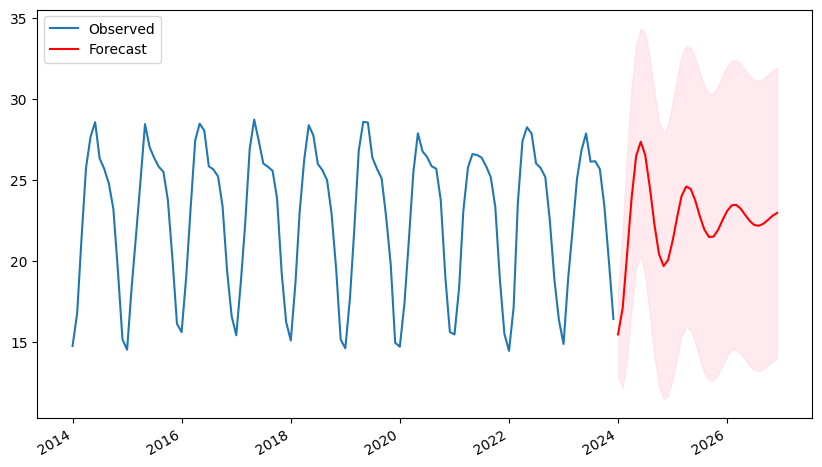

In [16]:
# Let's start forecasting! First up is ARIMA.

# Define the model
arima = ARIMA(t_series, order=(2,0,1))

# Fit the model
arima_fit = arima.fit()

# summary of fit model
print(arima_fit.summary())

# Forecast future values (e.g., next 36 months)
forecast = arima_fit.get_forecast(steps=36)
forecast_ci = forecast.conf_int()

# Plotting the actual vs forecasted data
plt.figure(figsize=(10, 6))
plt.plot(t_series, label='Observed')
forecast.predicted_mean.plot(label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

The AR(1) and AR(2) terms are highly significant, indicating that the time series has strong autocorrelation with the first and second lags. However, the MA(1) term is insignificant, suggesting that the moving average component might not add much value to this model. Diagnostic tests show no signs of significant residual autocorrelation, normality issues, or heteroskedasticity, which supports the validity of the model. 

The model is able to capture the trend and autocorrelation in the data, but the high standard error for the MA and sigma² components indicates potential overfitting or unnecessary model complexity. Though ARIMA is a powerful tool for univariate forecasting, it does not well support time series with a seasonal component, causing the forecasted temperature to be damped-oscillation-like. If we forecast it to a few more timesteps, we will certainly get a flat line.

Let's see how SARIMA performs.

### SARIMA Model Results

#### Model Fitting, Diagnostics, and Visualization

                                        SARIMAX Results                                        
Dep. Variable:                                     t2m   No. Observations:                  120
Model:             SARIMAX(2, 0, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -120.835
Date:                                 Mon, 21 Oct 2024   AIC                            253.669
Time:                                         15:27:41   BIC                            269.055
Sample:                                     01-01-2014   HQIC                           259.888
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2225      0.978      0.228      0.820      -1.694       2

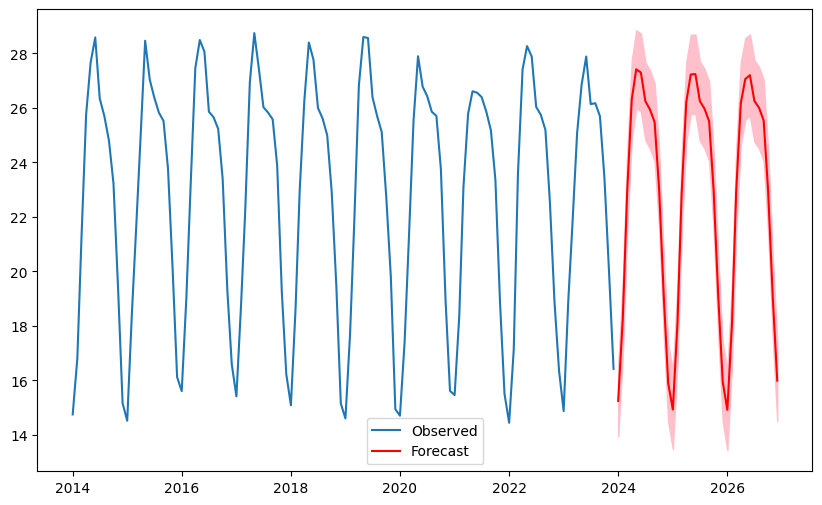

In [17]:
# Define the model
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    sarima = sm.tsa.statespace.SARIMAX(t_series, order=(2,0,1), seasonal_order=(0,2,2,12))
    sarima_fit = sarima.fit()

# summary of fit model
print(sarima_fit.summary())

# Forecast future values (e.g., next 36 months)
forecast = sarima_fit.get_forecast(steps=36)
forecast_ci = forecast.conf_int()

# Plotting the actual vs forecasted data
plt.figure(figsize=(10, 6))
plt.plot(t_series, label='Observed') 
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink') 
plt.legend()
plt.show()

The results are quite interesting! 

Visually, we can see the seasonal component being considered while forecasting; however, statistically, there are some caveats. Despite the inclusion of both non-seasonal and seasonal components, none of the AR, MA, or seasonal terms are statistically significant, with all p-values being much larger than 0.05. This suggests that the model might not be capturing meaningful patterns in the data or that it is over-parameterized. The sigma² (variance of residuals) is small but statistically insignificant, further suggesting model issues.

Diagnostic tests such as Ljung-Box, Jarque-Bera, and heteroskedasticity tests suggest that the residuals are well-behaved: they are normally distributed, with no significant autocorrelation or heteroskedasticity. However, the coefficients' insignificance indicates that the model could be simplified, possibly by removing some of the non-significant seasonal and non-seasonal components. 

Although the model is statistically sound in terms of residual diagnostics, it does not appear to provide meaningful or significant parameter estimates. One notable issue is the discrepancy in the AIC values. When finding the optimal parameters, the AIC for SARIMA(2, 0, 1)x(0, 2, 2, 12) was 12, but in the SARIMAX results above, the AIC is considerably larger. One possible reason is the model convergence. SARIMA models rely on iterative optimization to estimate parameters. If the optimization process differs between runs, the AIC can vary. In the `arima_sarima_best_fit()` function, we limited the number of iterations to 100. In some cases, while the function may have found parameter estimates, the optimization might have been cut short, leading to premature termination before proper convergence. This could result in suboptimal parameter estimates and a different, typically higher, AIC value.

### Comparative Analysis of ARIMA and SARIMA

Let's compare the forecasts. From visual inspection, we can clearly see that SARIMA is performing much better than ARIMA. AIC values inform which model is a relatively better fit; however, they do not evaluate the model's predictive performance. For that, we should investigate errors.

The straightforward way to do that is to perform a Train-Test split with observed/historical data

In [18]:
# Splitting the data in an 80:20 ratio. 80% for training and 20% for testing
train = t_series[:96]  # 2014-2021 (96 months)
test = t_series[96:]   # 2022-2023 (24 months)

In [19]:
# Fit ARIMA and SARIMA on training data. Model parameters are the same as for entire timeseries.
arima = sm.tsa.ARIMA(train, order=(2, 1, 1)).fit()
sarima = sm.tsa.SARIMAX(train, order=(2, 0, 1), seasonal_order=(0, 2, 2, 12)).fit()

# Forecast 24 steps ahead (2022-2023)
forecast_arima = arima.forecast(steps=24)
forecast_sarima = sarima.forecast(steps=24)

# Compare forecasts to actual test data (2022-2023)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    mae_arima = mean_absolute_error(test, forecast_arima)
    rmse_arima = root_mean_squared_error(test, forecast_arima)
    mae_sarima = mean_absolute_error(test, forecast_sarima)
    rmse_sarima = root_mean_squared_error(test, forecast_sarima)

# Print comparison of the models
print(f"ARIMA: MAE = {mae_arima}, RMSE = {rmse_arima}")
print(f"SARIMA: MAE = {mae_sarima}, RMSE = {rmse_sarima}")


C:\Users\Saurabh Kelkar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA: MAE = 2.488394935089405, RMSE = 3.049575299813202
SARIMA: MAE = 0.7040116850779915, RMSE = 0.8601287143153574


> The warning indicates that there may be too few observations to estimate the seasonal component of your SARIMA model properly. SARIMA needs enough seasonal cycles (typically at least two complete seasonal cycles) to estimate its parameters well. One approach is to reduce the seasonal order (P, D, Q, s) since there may not be enough data to estimate the seasonal parameters. We can also try reducing the complexity of the seasonal component.

#### Statistical Diagnostics vs. Predictive Power

- The SARIMAX results for SARIMA indicated that the parameters (such as AR and MA terms) were not statistically significant, which could imply that the model is not meaningfully explaining the underlying structure of the data.
- Despite this, the **SARIMA model** still performs significantly better in terms of **predictive accuracy** (lower MAE and RMSE) compared to ARIMA. This means that, even if the parameter estimates aren't individually significant, the model as a whole is still capturing essential features of the data, like seasonality, more effectively than ARIMA.

#### Residual Diagnostics and Parameter Significance
- While residual diagnostics (like Ljung-Box and Jarque-Bera tests) suggest that the SARIMA model fits well, the lack of significant parameter estimates might indicate some overfitting.
- However, **model diagnostics** serve as only one part of evaluating a model’s performance. Since we are also focused on **predictive accuracy** (via MAE and RMSE), it suggests that, despite its limitations in parameter significance, SARIMA is still more effective at forecasting than ARIMA.

#### Implications for Model Choice
- While ARIMA provides simpler and more interpretable parameters, its predictive power is lower.
- **SARIMA's ability to handle seasonality** outweighs the concerns about insignificant parameters, making SARIMA the better model in this case for **forecasting** rather than just interpreting the model’s internal dynamics.

## Conclusion:
- The SARIMA model is preferred for its predictive strength (even if some parameter estimates aren’t significant). The goal is to find the model that gives the most accurate predictions, and SARIMA outperforms ARIMA by a significant margin in this regard.
- The earlier concern about the SARIMA model’s parameter estimates highlights a trade-off between **model interpretability** and **forecast accuracy**. For our dataset, **forecast accuracy** (lower MAE and RMSE) is the dominant factor, making SARIMA the superior model for practical purposes.

## Reference
1. J. Noble, ARIMA models. What are ARIMA models? (2024), (available at https://www.ibm.com/topics/arima-model).
2. A. Hayes, Autoregressive Integrated Moving Average (ARIMA) Prediction Model. Investopedia (2024), (available at https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp).
3. A. Bajaj, ARIMA & SARIMA: Real-World Time Series Forecasting. Neptune Blog (2023), (available at https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide).
4. J. Frost, Autocorrelation and Partial Autocorrelation in Time Series Data. Statistics by Jim, (available at https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/).
5. D. Mallick, Interpreting ACF or Auto-correlation plot. Medium (2021), (available at https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14).
6. J. Forrest-Baldini, SARIMAX Gridsearch (2022), (available at https://gist.github.com/JessicaFB/af4c9d12ec8314cff56b5e0f18b8e61c).